In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/Users/juliankimura/Desktop/deepomics')
import deepomics.neuralnetwork as nn
from deepomics import learn, utils
from models import vae_Frey_model

import theano
import theano.tensor as T
from lasagne import layers

In [2]:
filename = 'frey_rawface.mat'
data_path = '/Users/juliankimura/Desktop/data/FreyFaces'
matfile = loadmat(os.path.join(data_path, filename))
all_data = (matfile['ff'] / 255.).T

indices = np.arange(len(all_data))
np.random.shuffle(indices)
indices

width = 20
height = 28
X_train = all_data[indices[:1500]]
X_valid = all_data[indices[1500:]]

/Users/juliankimura/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


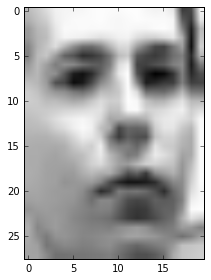

In [3]:
plt.imshow(X_train[10].reshape([height,width]),cmap='gray')

In [4]:
input_shape = list(X_train.shape)
input_shape[0] = None
network, placeholders, optimization = vae_Frey_model.model(input_shape)

In [5]:
# build neural network class
nnmodel = nn.NeuralNet(network, placeholders)
nnmodel.inspect_layers()

# set output file paths
output_name = 'Frey_faces'
results_path = utils.make_directory(data_path, 'Results')
results_path = utils.make_directory(results_path, output_name)
file_path = os.path.join(results_path, output_name)
nntrainer = nn.NeuralTrainer(nnmodel, optimization, save='best', file_path=file_path)

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: 
shape:(None, 560)
layer2: 
shape:(None, 200)
parameters: W
layer3: 
shape:(None, 200)
parameters: b
layer4: 
shape:(None, 200)
layer5: 
shape:(None, 100)
parameters: W
layer6: 
shape:(None, 100)
parameters: b
layer7: 
shape:(None, 100)
layer8: 
shape:(None, 2)
parameters: W, b
layer9: 
shape:(None, 2)
parameters: W, b
layer10: 
shape:(None, 2)
layer11: 
shape:(None, 100)
parameters: W
layer12: 
shape:(None, 100)
parameters: b
layer13: 
shape:(None, 100)
layer14: 
shape:(None, 200)
parameters: W
layer15: 
shape:(None, 200)
parameters: b
layer16: 
shape:(None, 200)
layer17: 
shape:(None, 560)
parameters: W
layer18: 
shape:(None, 560)
parameters: b
layer19: 
shape:(None, 560)
----------------------------------------------------------------------------
compiling model


In [6]:
# train model
learn.train_minibatch(nntrainer, data={'train': X_train, 'valid': X_valid}, 
                              batch_size=100, num_epochs=500, patience=50, verbose=0)


  valid loss:		136.97729
  valid squared loss:	0.04811
saving model parameters to: /Users/juliankimura/Desktop/data/FreyFaces/Results/Frey_faces/Frey_faces_best.pickle

  valid loss:		86.50891
  valid squared loss:	0.04336
saving model parameters to: /Users/juliankimura/Desktop/data/FreyFaces/Results/Frey_faces/Frey_faces_best.pickle

  valid loss:		55.39221
  valid squared loss:	0.04034
saving model parameters to: /Users/juliankimura/Desktop/data/FreyFaces/Results/Frey_faces/Frey_faces_best.pickle

  valid loss:		43.41780
  valid squared loss:	0.03535
saving model parameters to: /Users/juliankimura/Desktop/data/FreyFaces/Results/Frey_faces/Frey_faces_best.pickle

  valid loss:		38.53342
  valid squared loss:	0.03402
saving model parameters to: /Users/juliankimura/Desktop/data/FreyFaces/Results/Frey_faces/Frey_faces_best.pickle

  valid loss:		34.13118
  valid squared loss:	0.03835
saving model parameters to: /Users/juliankimura/Desktop/data/FreyFaces/Results/Frey_faces/Frey_faces_bes

/Users/juliankimura/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


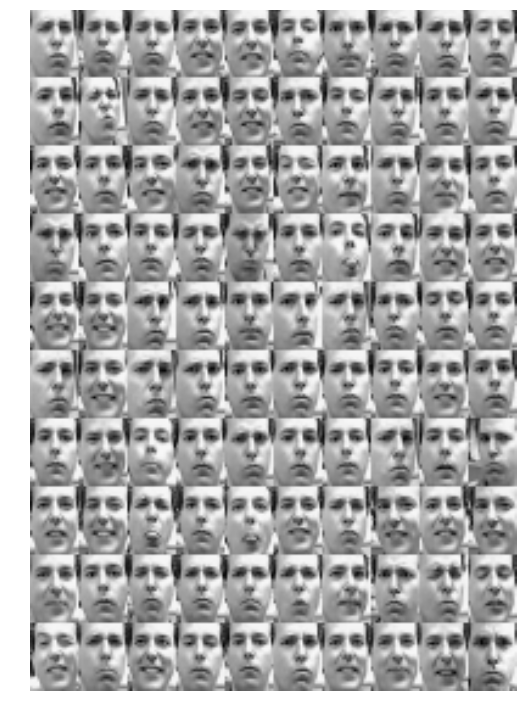

In [7]:
num_steps = 10
samples = X_train[:num_steps*num_steps,:]
fig = plt.figure()
plt.imshow((samples.reshape(num_steps, num_steps, 28, 20)
                   .transpose(0, 2, 1, 3)
                   .reshape(num_steps*28, num_steps*20)), cmap='gray')
plt.axis('off')
fig.set_size_inches(10,10)

/Users/juliankimura/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


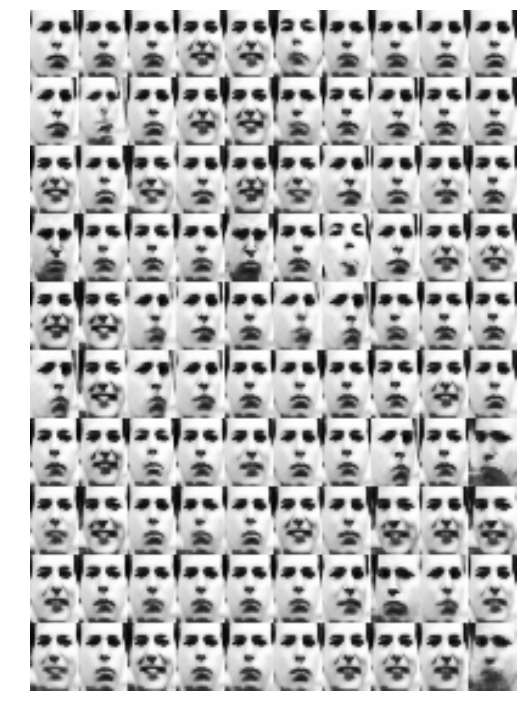

In [8]:
generated_x = layers.get_output(nnmodel.network['X'], deterministic=True)
gen_fn = theano.function([nnmodel.placeholders['inputs']], generated_x)
num_grid = 10
k = 0
reconstructed_samples = []
for i in range(num_grid):
    for j in range(num_grid):
        reconstructed_samples.append(gen_fn(np.expand_dims(samples[k], axis=0)))
        k += 1
reconstructed_samples = np.array(reconstructed_samples)        
               
fig = plt.figure()
plt.imshow((reconstructed_samples.reshape(num_grid, num_grid, 28, 20)
                   .transpose(0, 2, 1, 3)
                   .reshape(num_grid*28, num_grid*20)), cmap='gray')
plt.axis('off')
fig.set_size_inches(10,10)

In [10]:
z_var = T.vector()
generated_x = layers.get_output(nnmodel.network['X'], {nnmodel.network['encode_mu']: z_var}, deterministic=True)
gen_fn = theano.function([z_var], generated_x)
num_grid = 20
pos = np.linspace(-4, 4, num_grid)
generated_samples = []
for i in range(num_grid):
    for j in range(num_grid):
        z = np.asarray([pos[i], pos[j]], dtype=theano.config.floatX)
        generated_samples.append(gen_fn(z))
generated_samples = np.array(generated_samples)        
                
     
fig = plt.figure()
plt.imshow((generated_samples.reshape(num_grid, num_grid, 28, 20)
                   .transpose(0, 2, 1, 3)
                   .reshape(num_grid*28, num_grid*20)), cmap='gray')
plt.axis('off')
fig.set_size_inches(10,10)

ValueError: ('You cannot drop a non-broadcastable dimension.', ((False,), ('x',)))